In [1]:
# Import necessary libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import random
import torch
from scipy.fft import rfft, rfftfreq
import pywt

In [2]:
# --- ⚙️ Configuration ---

# Paths to the human data directories
HUMAN_FILE_PATHS = [
    '/Users/anuragde/Documents/project-work/mydata/human/person1_office_table_sitting/signal_5000.csv',
    '/Users/anuragde/Documents/project-work/mydata/human/person2_standing_with_jacket/signal_2500.csv'
]

# Paths to the non-human data directories
NONHUMAN_FILE_PATHS = [
    '/Users/anuragde/Documents/project-work/mydata/nonhuman/chair_without_anything_empty/signal_2500.csv',
    '/Users/anuragde/Documents/project-work/mydata/nonhuman/office_table_with_books/signal_5000.csv',
    '/Users/anuragde/Documents/project-work/mydata/nonhuman/chair_with_bag_and_jacket/signal_5000.csv'
]

# --- Analysis Parameters ---
# The sampling rate of the ADC signal in Hz
SAMPLING_RATE = 1953125

# Number of initial columns/samples to skip in the CSV data
COLUMNS_TO_REMOVE = 5500

In [3]:
def final_complete_visualization(filename, sampling_rate, columns_to_remove):
    """    
    Generates a comprehensive 8-panel plot,
    -   Time-Domain Signal
    -   Autocorrelation
    -   Hamming Windowed Autocorrelation
    -   Power Spectral Density (PSD)
    -   Full FFT Spectrum
    -   Normalized FFT (in a specific frequency range)
    -   Wavelet Scalogram
    -   Spectrogram (in dB) 
    
    for a randomly selected signal from the specified file.
   """
    try:
        # --- Load Data and Select a Random Row ---
        data_matrix = pd.read_csv(filename, header=None).values
        num_rows = data_matrix.shape[0]
        selected_index = random.randint(0, num_rows - 1)
        
        # --- Prepare Signal ---
        signal = data_matrix[selected_index, columns_to_remove:]
        foldername = os.path.basename(os.path.dirname(filename))
        print(f"  Successfully loaded signal from '{foldername}'.")

        # --- Perform All Analyses ---

        # Autocorrelation & PSD
        autocorr = np.correlate(signal - np.mean(signal), signal - np.mean(signal), mode='full')
        autocorr = autocorr[len(autocorr)//2:]
        autocorr_hamming = autocorr * np.hamming(len(autocorr))
        psd = np.abs(rfft(autocorr_hamming))
        freqs_psd = rfftfreq(len(autocorr_hamming), 1/sampling_rate)
        
        # Direct FFT
        N_fft = len(signal)
        fft_vals = np.abs(rfft(signal))
        freqs_direct = rfftfreq(N_fft, 1 / sampling_rate)
        fft_normalized = (fft_vals - fft_vals.min()) / (fft_vals.max() - fft_vals.min())

        # Wavelet Transform
        signal_subset = signal[12000:15000]
        scales = np.arange(35, 65)
        coefficients, wavelet_freqs = pywt.cwt(signal_subset, scales, 'morl', sampling_period=1/sampling_rate)
        
        # Spectrogram Calculation (STFT)
        signal_tensor = torch.from_numpy(signal.astype(np.float32))
        n_fft, hop_length = 256, 128
        window = torch.hann_window(n_fft)
        spec_complex = torch.stft(signal_tensor, n_fft=n_fft, hop_length=hop_length, window=window, return_complex=True)
        spectrogram = torch.abs(spec_complex).numpy()
        
        # --- Generate 4x2 Plot Grid ---
        fig, axs = plt.subplots(4, 2, figsize=(16, 20))
        plot_title = f"Analysis for {foldername}"
        plt.suptitle(plot_title, fontsize=20)
        
        # Plot each analysis in its respective panel
        axs[0, 0].plot(signal)
        axs[0, 0].set_title("1. Time-Domain Signal")
        axs[0, 1].plot(autocorr)
        axs[0, 1].set_title("2. Autocorrelation")
        axs[1, 0].plot(autocorr_hamming, color='darkorange')
        axs[1, 0].set_title("3. Hamming Windowed Autocorrelation")
        psd_mask = (freqs_psd >= 30000) & (freqs_psd <= 50000)
        axs[1, 1].plot(freqs_psd[psd_mask]/1000, psd[psd_mask])
        axs[1, 1].set_title("4. Power Spectral Density (30-50 kHz)")
        axs[2, 0].plot(freqs_direct / 1000, fft_vals)
        axs[2, 0].set_title("5. FFT Whole Spectrum")
        freq_mask = (freqs_direct >= 30000) & (freqs_direct <= 50000)
        axs[2, 1].plot(freqs_direct[freq_mask]/1000, fft_normalized[freq_mask])
        axs[2, 1].set_title("6. Normalized FFT (30-50 kHz)")
        im = axs[3, 0].imshow(np.abs(coefficients), 
                              extent=[12000, 15000, wavelet_freqs[-1]/1000, wavelet_freqs[0]/1000], 
                              aspect='auto', cmap='viridis', interpolation='none')
        axs[3, 0].set_title("7. Wavelet Scalogram")
        fig.colorbar(im, ax=axs[3, 0], label='Magnitude')
        
        log_spectrogram = 20 * np.log10(np.maximum(1e-9, spectrogram))
        im_spec = axs[3, 1].imshow(log_spectrogram, aspect='auto', origin='lower', cmap='viridis')
        axs[3, 1].set_title("8. Spectrogram (dB)")
        fig.colorbar(im_spec, ax=axs[3, 1], format='%+2.0f dB', label='Intensity (dB)')

        # Adjust labels for all plots
        for i, ax in enumerate(axs.flat):
            ax.grid(True)
            if i in [0, 6]: ax.set_xlabel('Sample Index')
            if i in [1, 2]: ax.set_xlabel('Lag')
            if i in [3, 4, 5]: ax.set_xlabel('Frequency (kHz)')
            if i == 7: 
                ax.set_xlabel('Time Frames')
                ax.set_ylabel('Frequency Bins')
                
        plt.tight_layout(rect=[0, 0.03, 1, 0.97])
        
        print("  ✅ Plot generated. Displaying now...")
        print("  ℹ️ Row index used:", selected_index)
        plt.show()

    except FileNotFoundError:
        print(f"  ❌ Error: The file '{filename}' was not found.")
    except Exception as e:
        print(f"  ❌ An error occurred: {e}")

--- Processing Category: Human ---

-> Analyzing folder: 'person1_office_table_sitting'
  Successfully loaded signal from 'person1_office_table_sitting'.
  ✅ Plot generated. Displaying now...
  ℹ️ Row index used: 2266


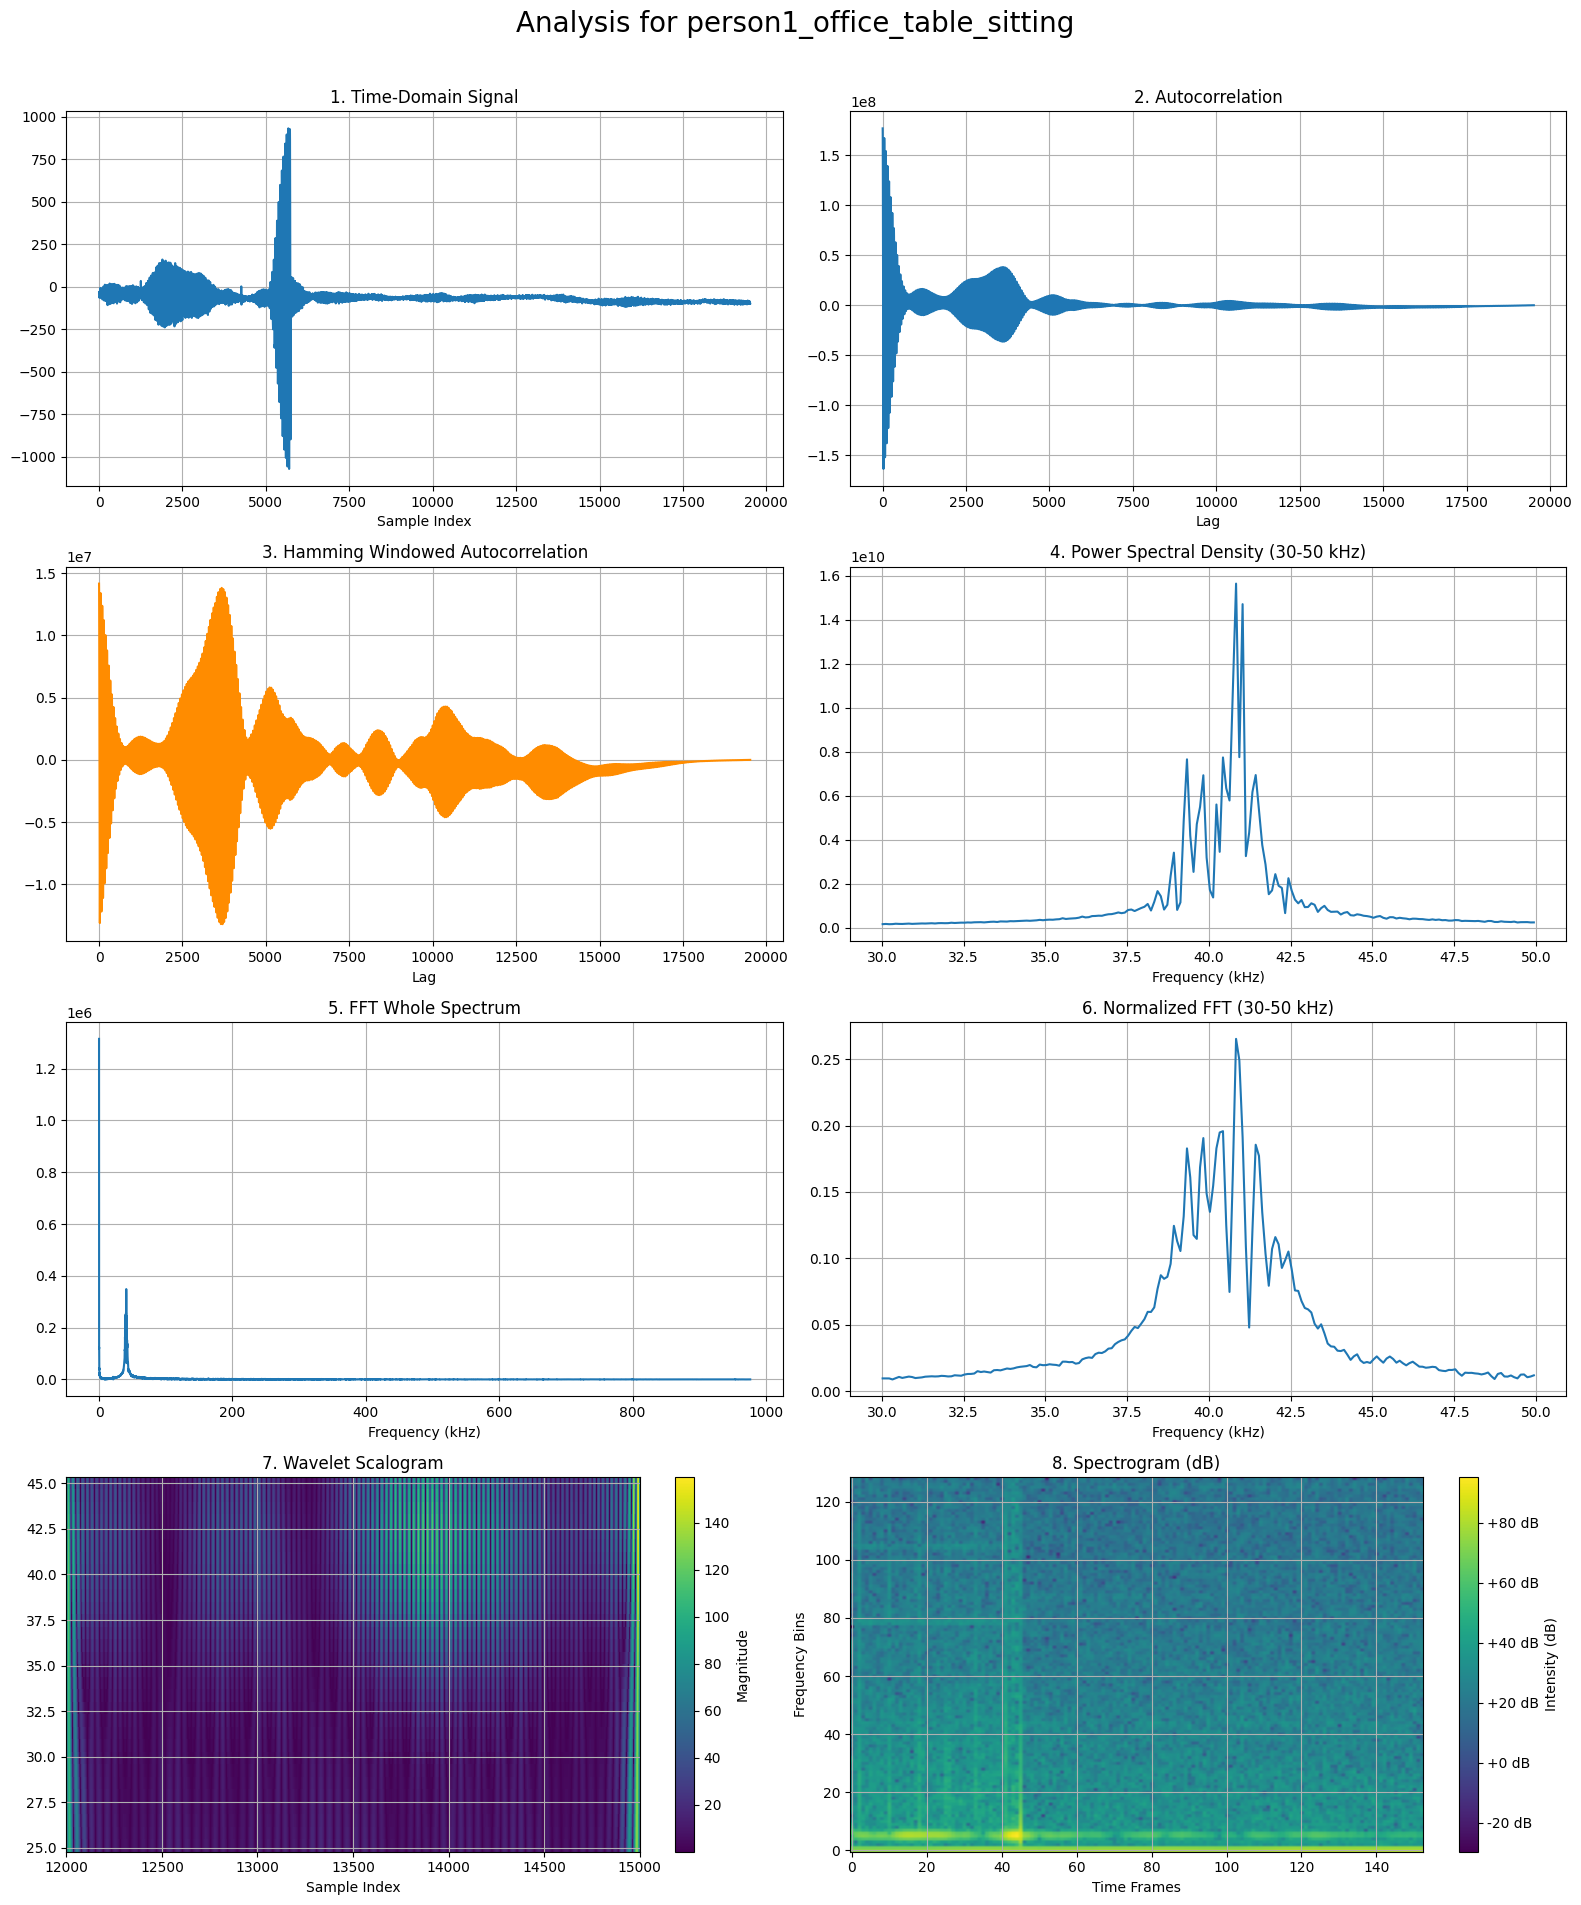


-> Analyzing folder: 'person2_standing_with_jacket'
  Successfully loaded signal from 'person2_standing_with_jacket'.
  ✅ Plot generated. Displaying now...
  ℹ️ Row index used: 1759


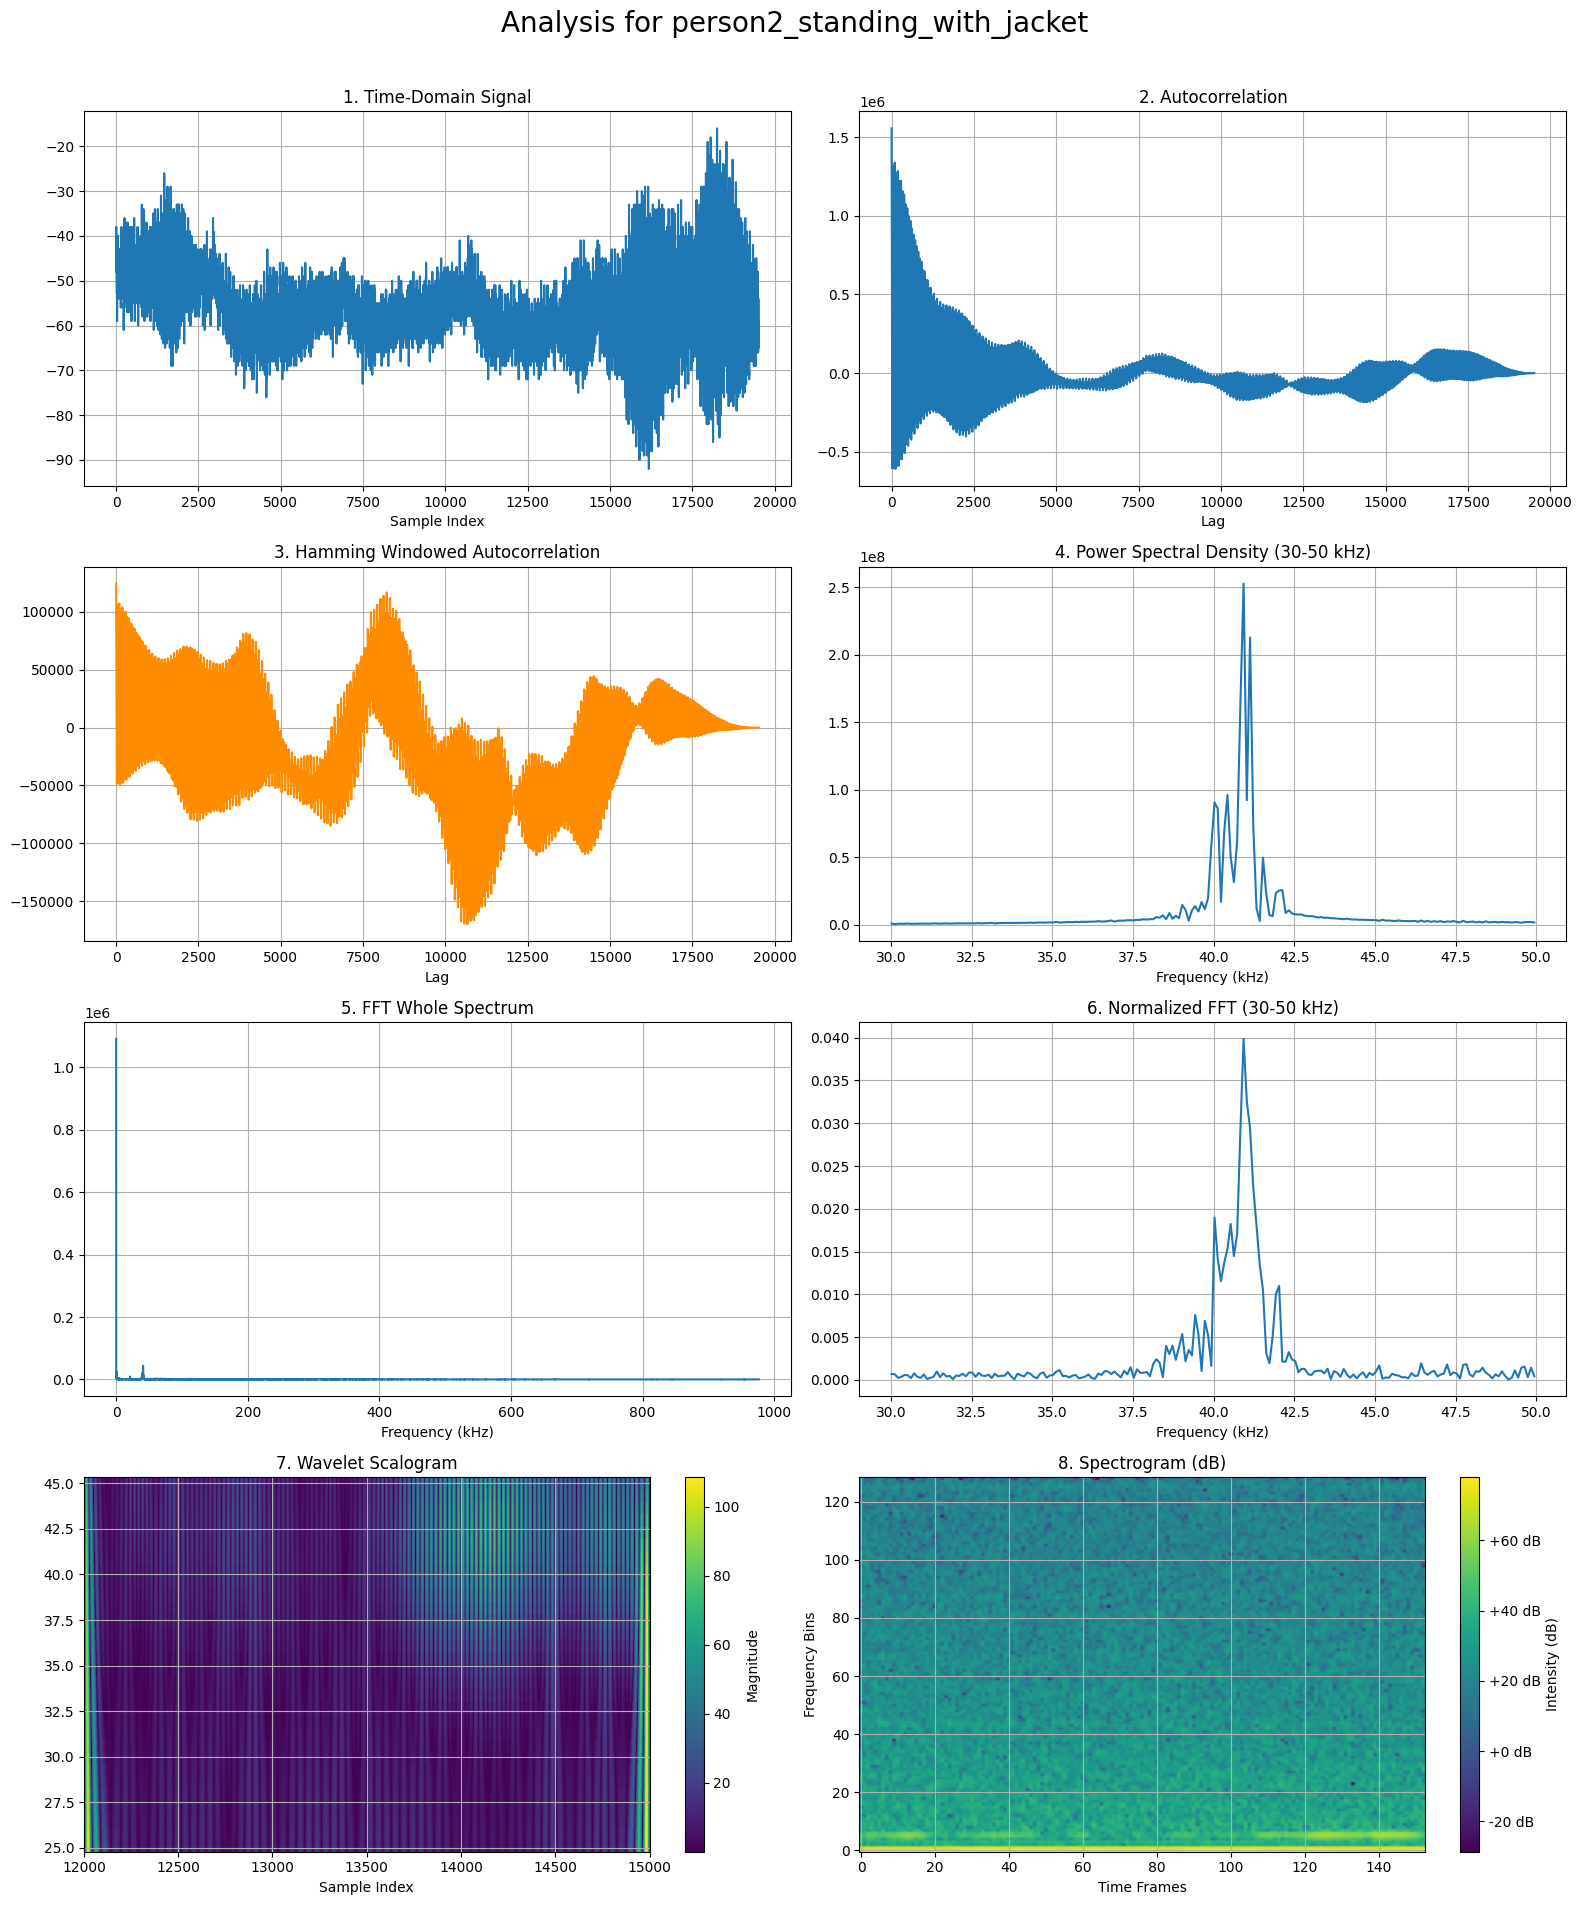

--- Processing Category: Nonhuman ---

-> Analyzing folder: 'chair_without_anything_empty'
  Successfully loaded signal from 'chair_without_anything_empty'.
  ✅ Plot generated. Displaying now...
  ℹ️ Row index used: 1304


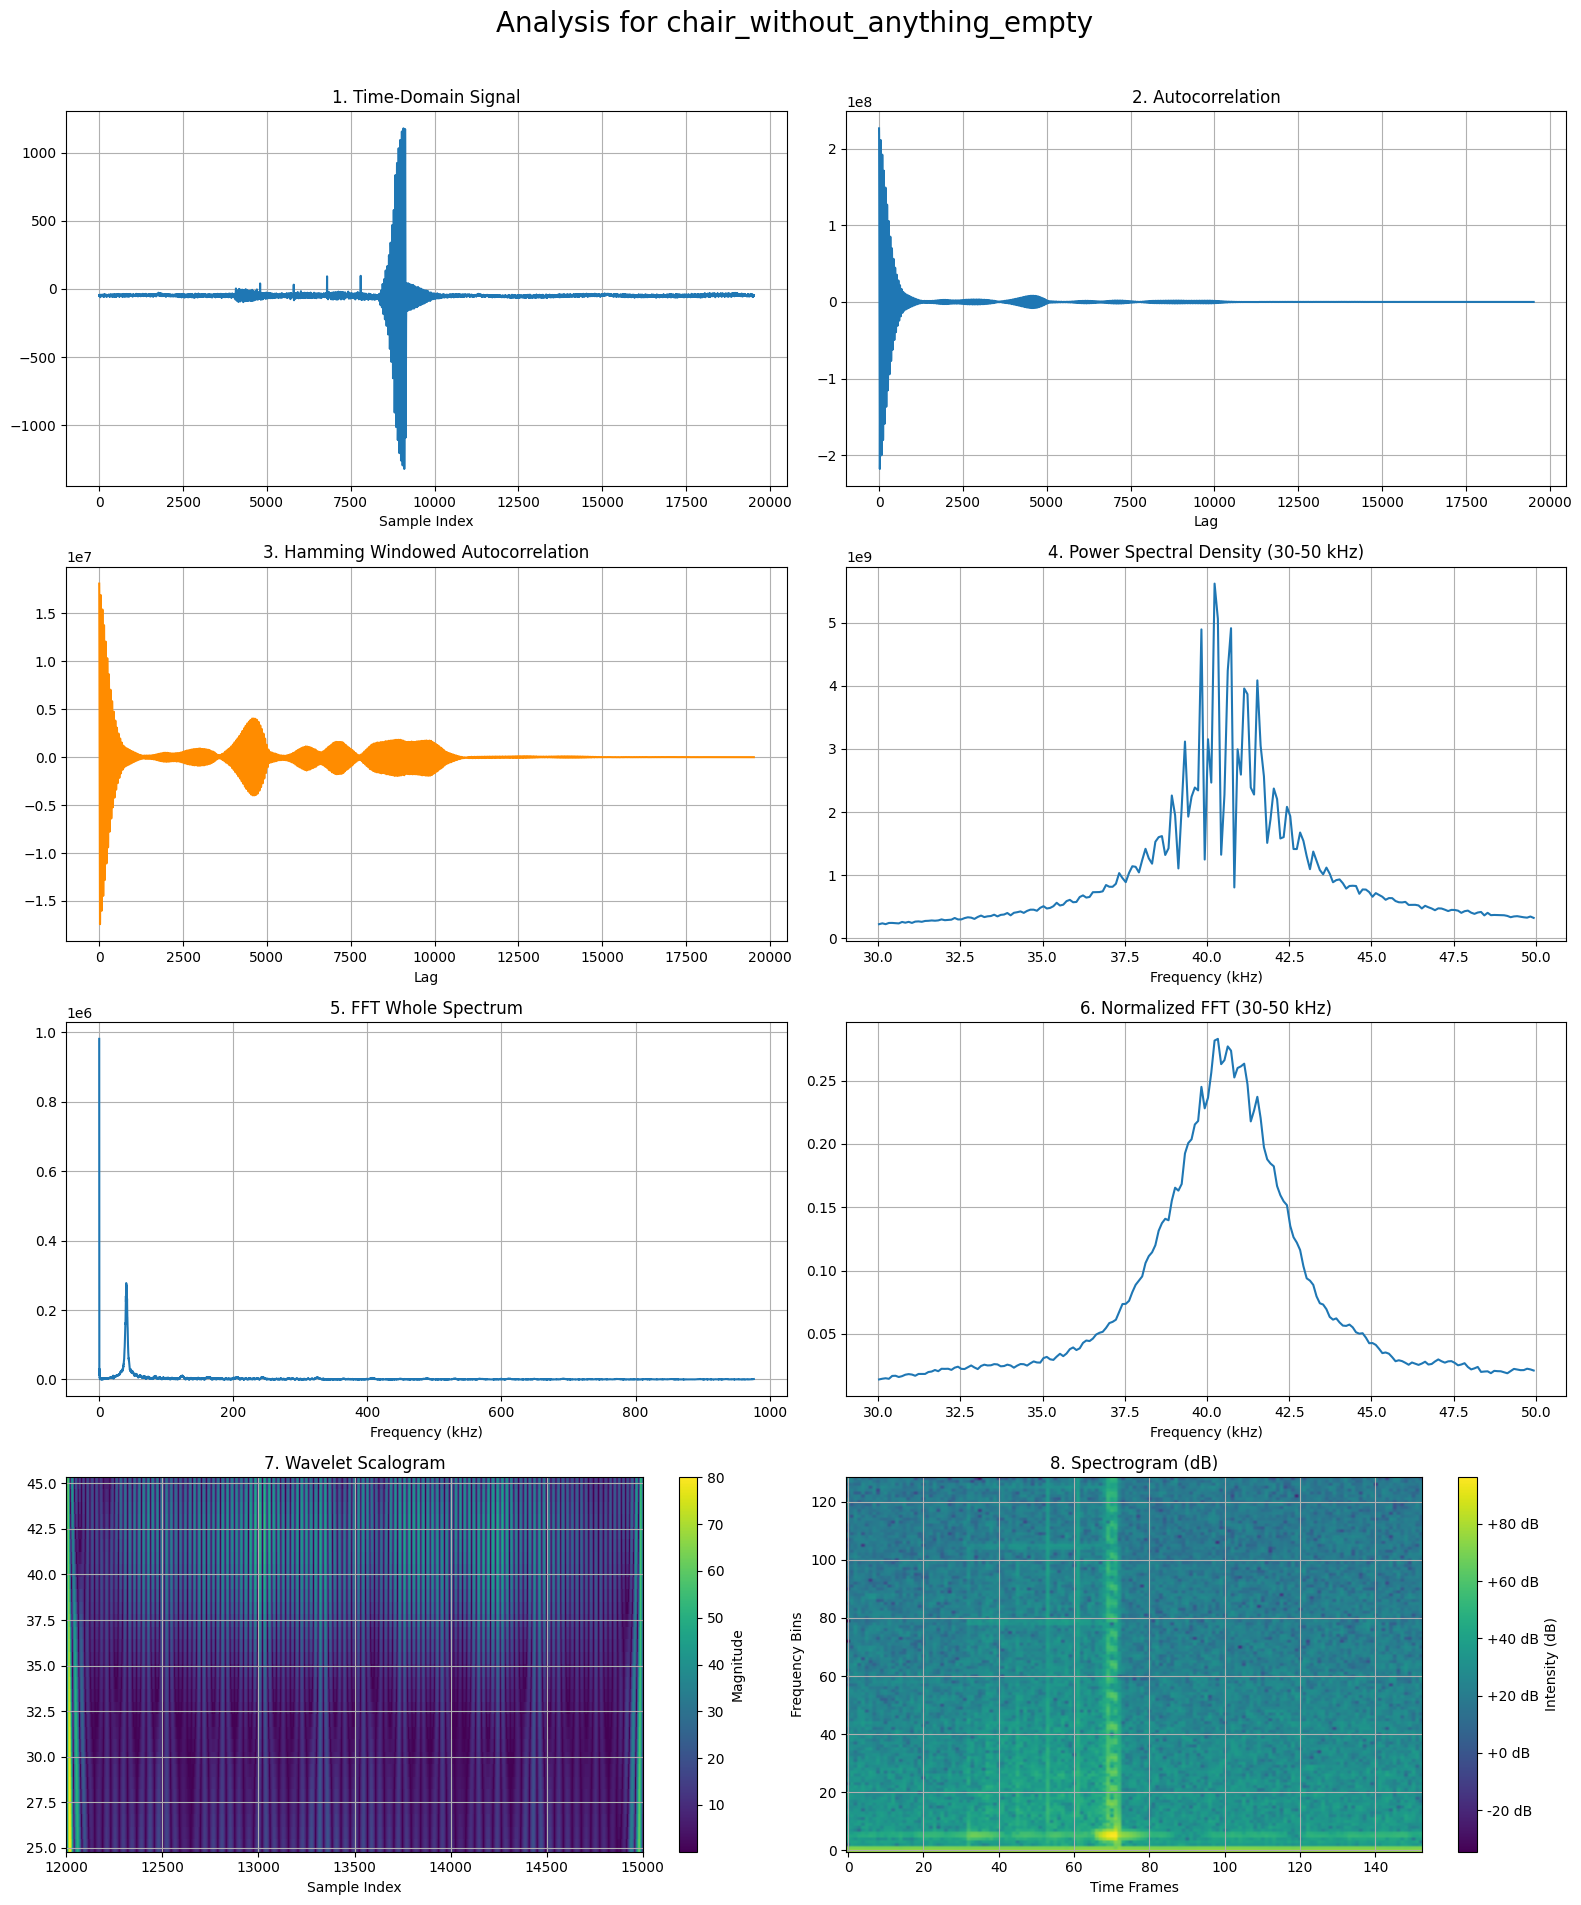


-> Analyzing folder: 'office_table_with_books'
  Successfully loaded signal from 'office_table_with_books'.
  ✅ Plot generated. Displaying now...
  ℹ️ Row index used: 1979


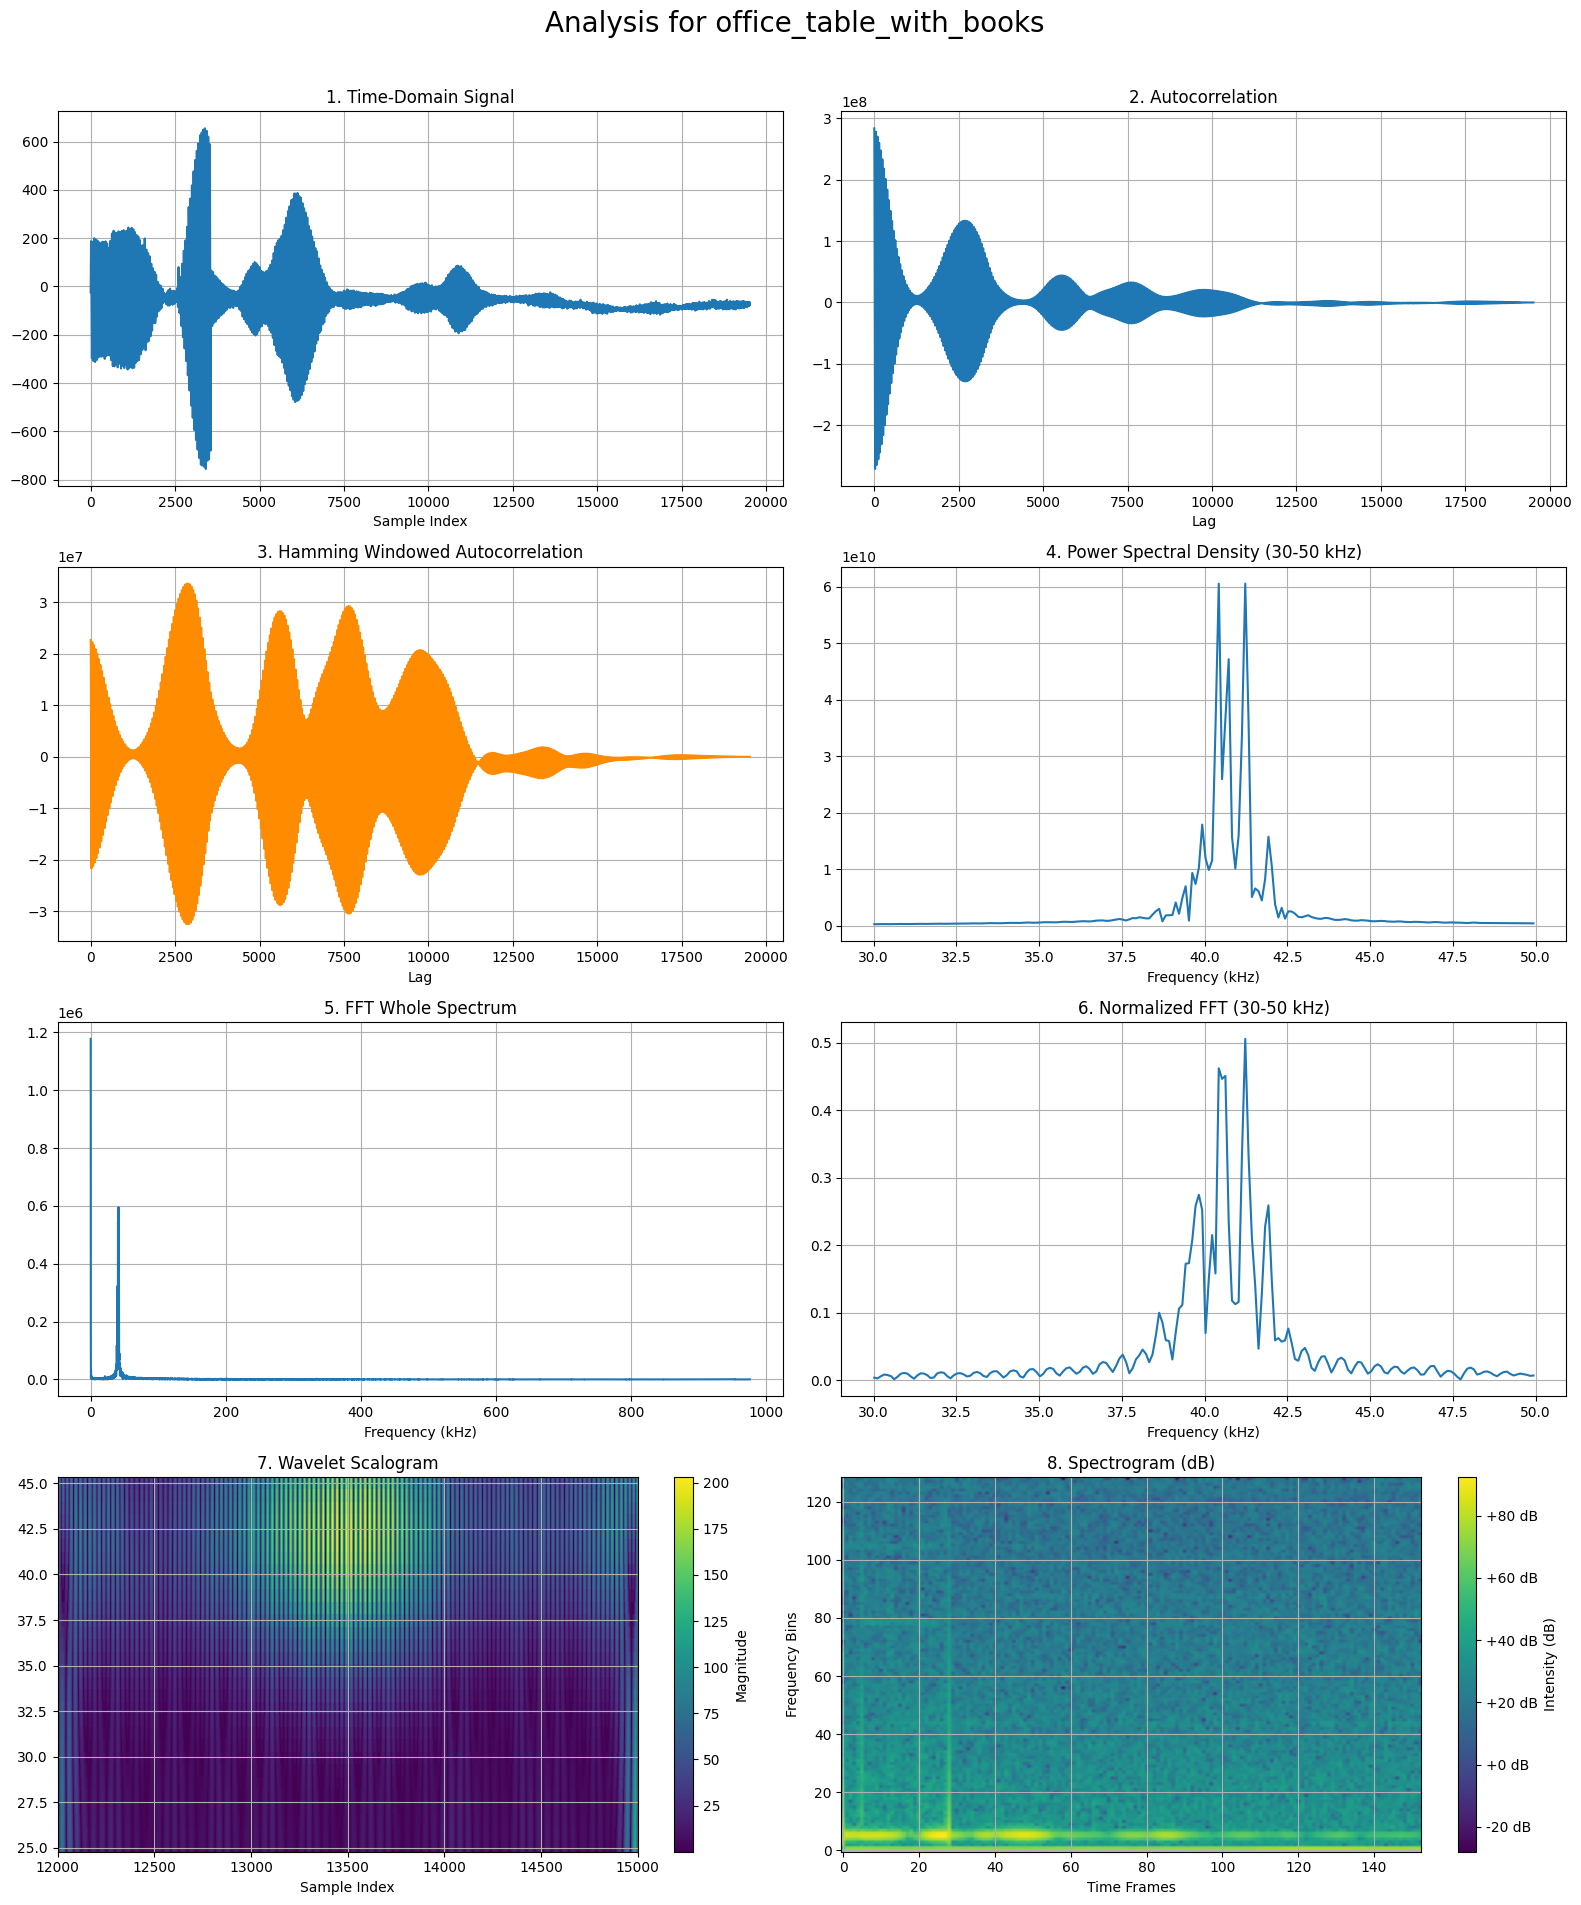


-> Analyzing folder: 'chair_with_bag_and_jacket'
  Successfully loaded signal from 'chair_with_bag_and_jacket'.
  ✅ Plot generated. Displaying now...
  ℹ️ Row index used: 624


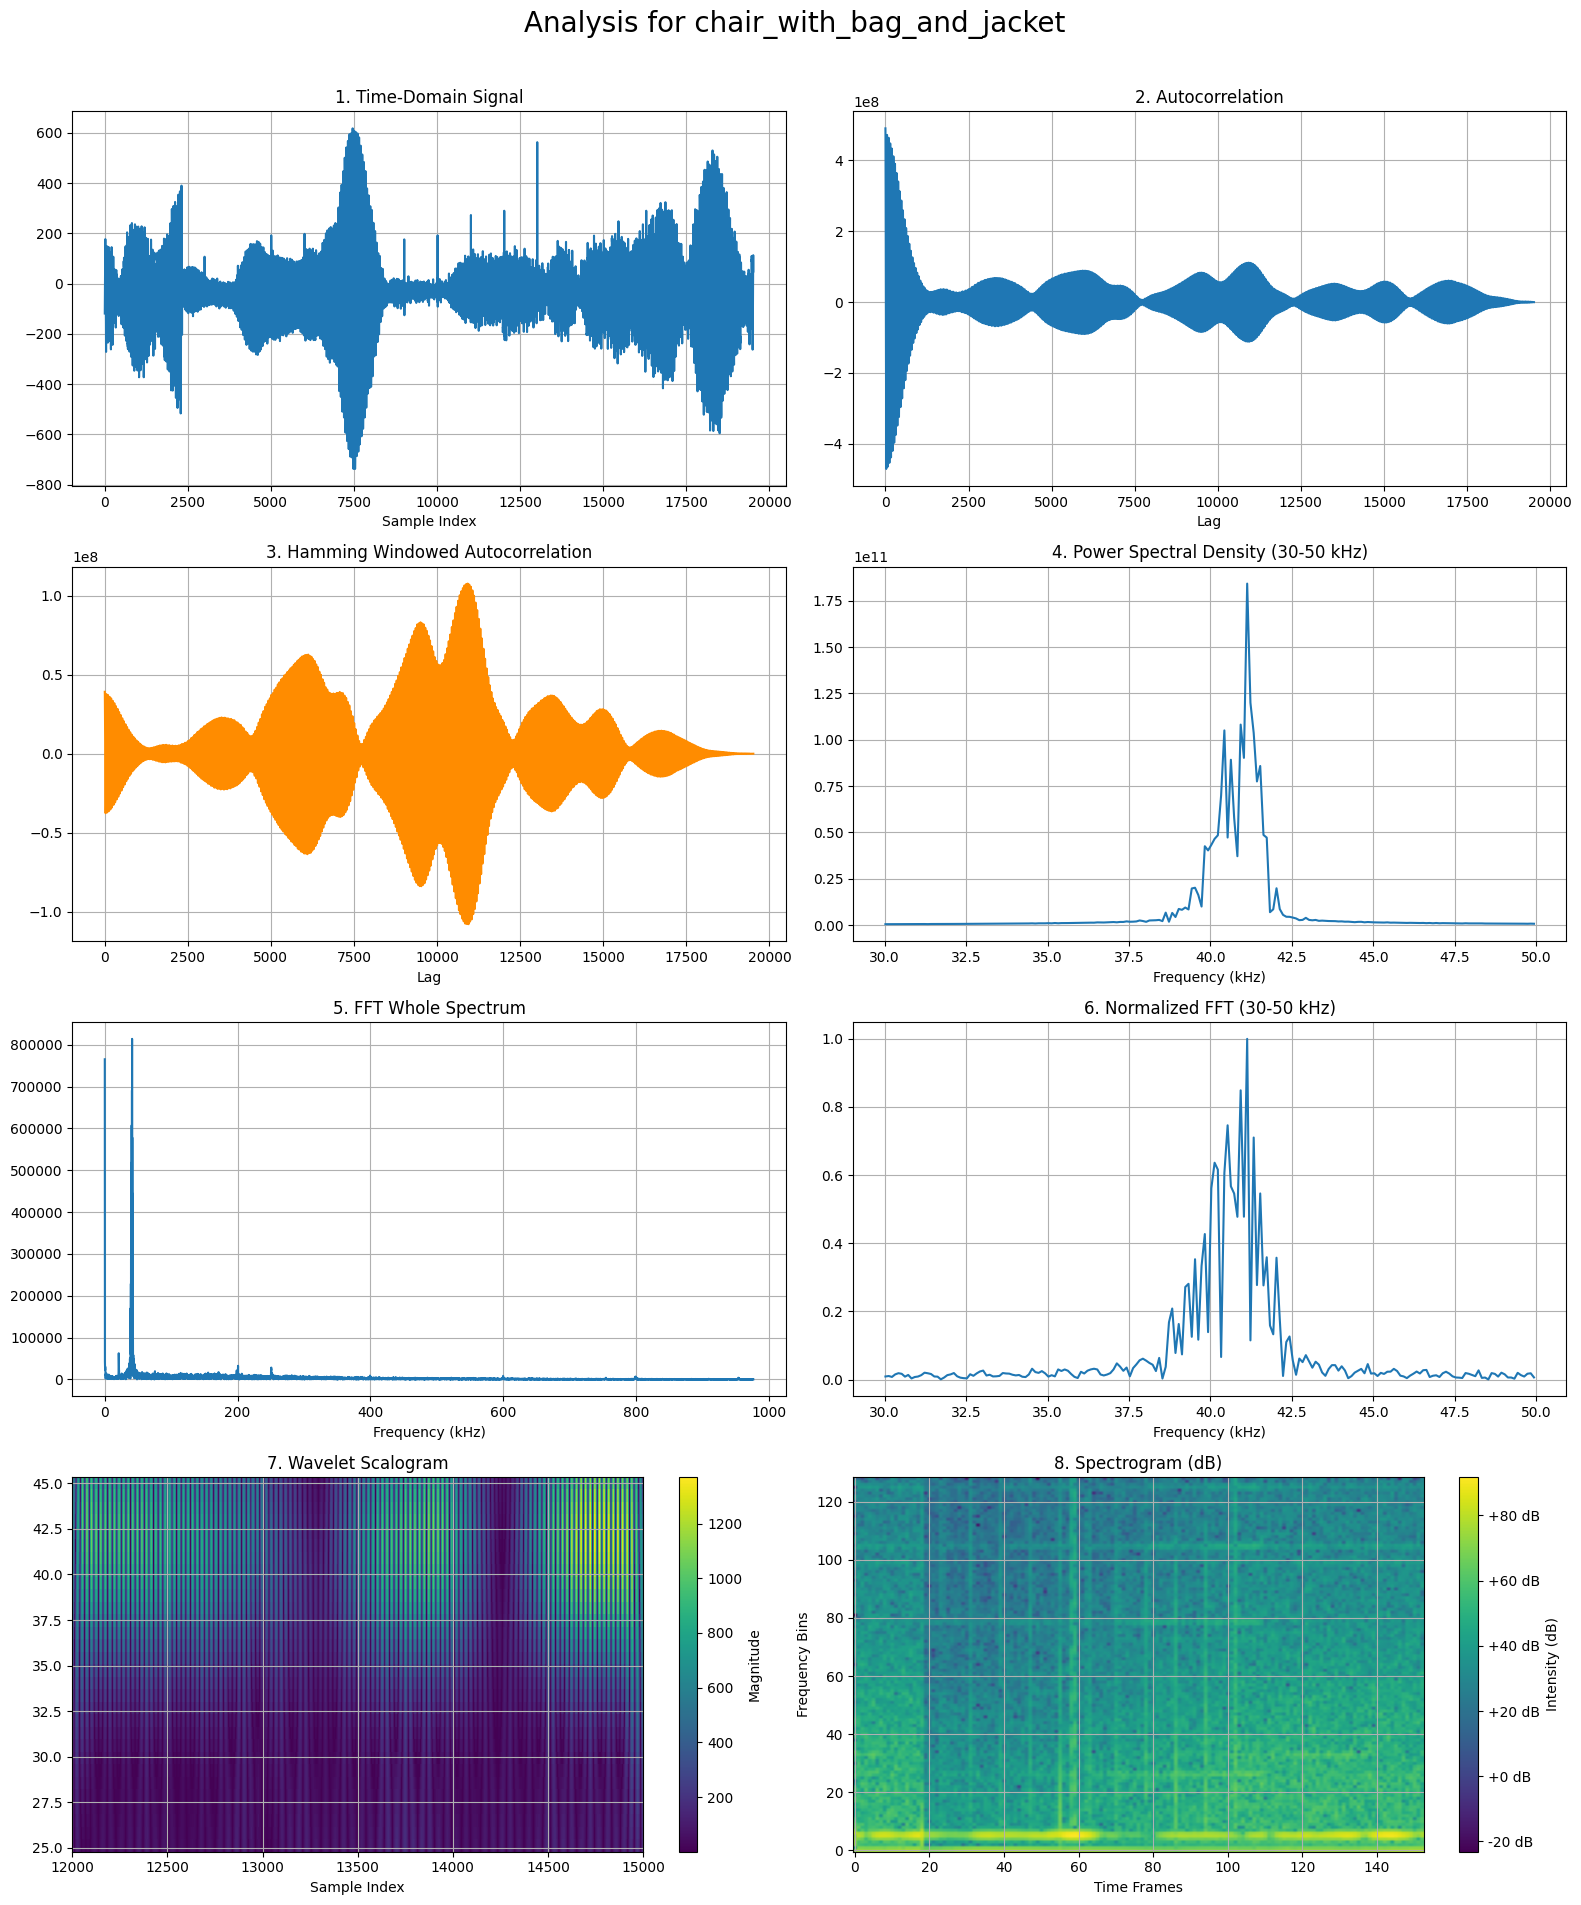


--- All files processed. ---


In [4]:
# --- ▶️ Execute the Visualization Loop ---

files_to_process = {
    "Human": HUMAN_FILE_PATHS,
    "Nonhuman": NONHUMAN_FILE_PATHS
}

for category, file_list in files_to_process.items():
    print(f"--- Processing Category: {category} ---")
    if not file_list or all(path.startswith('path/to/') for path in file_list):
        print("No files specified for this category. Skipping.")
        continue

    for filepath in file_list:
        print(f"\n-> Analyzing folder: '{os.path.basename(os.path.dirname(filepath))}'")
        if os.path.isfile(filepath):
            final_complete_visualization(
                filename=filepath,
                sampling_rate=SAMPLING_RATE,
                columns_to_remove=COLUMNS_TO_REMOVE
            )
        else:
            print(f"  ❌ Error: File not found at '{filepath}'")

print("\n--- All files processed. ---")